# Code for Final Prediction Competition

# Imports

In [73]:
import numpy as np, pandas as pd
from sklearn.model_selection import (train_test_split , GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer

# PreProcessing Section

In [74]:
# Read in Data
data = pd.read_csv("./data/glassdoor_training_small_v1.csv")
print(data.head())

   overall_rating           firm date_review          job_title  \
0               1            IBM  2008-06-21              Sales   
1               4       Deloitte  2008-06-16                      
2               3            IBM  2008-07-21                      
3               4      Microsoft  2008-08-23    Program Manager   
4               5  Capital-Group  2008-09-18   Business Analyst   

        location                                           headline  \
0  Rochester, NY                                               Good   
1    Toronto, ON            Are you going to send this to Deloitte?   
2  Lexington, MA  Big, slow and complex. A place to hide or a pl...   
3   Bellevue, WA                                   Happy - for now.   
4            NaN   stable company, fair compensation, great culture   

                                                pros  \
0  close to my home which can save my transportat...   
1  High standard and a lot of good people to work...   
2 

In [75]:
data.drop(['small'], axis="columns",inplace=True)
data.drop(columns=["location","firm","date_review"],inplace=True)

In [76]:
# output to csv file
csv_file_out = "./data/preprocessing.csv"

# Save the DataFrame to a CSV file
data.to_csv(csv_file_out,index=False, encoding="utf-8", float_format="%1.6f")

In [77]:
df = pd.read_csv("./data/preprocessing.csv", lineterminator='\n')
print(df.head())

   overall_rating          job_title  \
0               1              Sales   
1               4                      
2               3                      
3               4    Program Manager   
4               5   Business Analyst   

                                            headline  \
0                                               Good   
1            Are you going to send this to Deloitte?   
2  Big, slow and complex. A place to hide or a pl...   
3                                   Happy - for now.   
4   stable company, fair compensation, great culture   

                                                pros  \
0  close to my home which can save my transportat...   
1  High standard and a lot of good people to work...   
2  A recognizable name and fair to decent benefit...   
3  Working with the latest technology and mature ...   
4  Great benefits and work life balance.  Also, c...   

                                                cons  year  
0                  get l

In [78]:
# Specify the columns you want to check for missing values
columns_to_check = ['pros', 'cons', 'headline']

# Check for missing values in the specified columns
df = df.dropna(subset=columns_to_check)
missing_values = df[columns_to_check].isna()
rows_with_missing_values = df[missing_values.any(axis=1)]
print(len(rows_with_missing_values))

0


# Sentiment Analysis Feature Construction

In [79]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jaimil.d/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jaimil.d/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimil.d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
df['pros'] = df['pros'].astype(str)
df['cons'] = df['cons'].astype(str)


In [81]:
# Feature construction
df['pros_length'] = df['pros'].apply(len)
df['cons_length'] = df['cons'].apply(len)
df['headline_sentiment'] = df['headline'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])
df['pros_sentiment'] = df['pros'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])
df['cons_sentiment'] = df['cons'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])

In [82]:
# Check missing values
print(df["headline_sentiment"].isna().values.any())
print(df["pros_sentiment"].isna().values.any())
print(df["cons_sentiment"].isna().values.any())

False
False
False


In [83]:
# Save Progress
csv_file_out = "./data/postsentiment.csv"
df.to_csv(csv_file_out,index=False, encoding="utf-8", float_format="%1.6f")

# Train Models

In [84]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Data Setup

In [85]:
df = pd.read_csv("./data/postsentiment.csv", lineterminator='\n')
print(df.head())
df.drop(columns=["headline"],inplace=True)

   overall_rating          job_title  \
0               1              Sales   
1               4                      
2               3                      
3               4    Program Manager   
4               5   Business Analyst   

                                            headline  \
0                                               Good   
1            Are you going to send this to Deloitte?   
2  Big, slow and complex. A place to hide or a pl...   
3                                   Happy - for now.   
4   stable company, fair compensation, great culture   

                                                pros  \
0  close to my home which can save my transportat...   
1  High standard and a lot of good people to work...   
2  A recognizable name and fair to decent benefit...   
3  Working with the latest technology and mature ...   
4  Great benefits and work life balance.  Also, c...   

                                                cons  year  pros_length  \
0         

In [86]:
# Features and target variable
features = ['pros_length', 'cons_length', 'headline_sentiment', 'pros_sentiment', 'cons_sentiment','year']
target = 'overall_rating'

In [87]:
# Specify our x and y
y = df['overall_rating']
X = df.drop(columns=['overall_rating','pros','cons','job_title'])

In [88]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training Neural Net MLP

In [89]:
# Model Building with Sigmoid Neuron
model = MLPRegressor(hidden_layer_sizes=(100), activation='logistic', max_iter=500, solver='adam')
model.fit(X_train, y_train)

# Make predictions
# y_train_pred = np.clip(model.predict(X_train),1, 5)
# y_test_pred = np.clip(model.predict(X_test),1,5)
y_train_pred = np.round(np.clip(model.predict(X_train),1, 5))
y_test_pred = np.round(np.clip(model.predict(X_test),1,5))

# Model Evaluation
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print MSE and R2 for the training set
print(f'MSE (Training Set): {mse_train}')
print(f'R2 Score (Training Set): {r2_train}')


# Print MSE and R2 for the training set
print(f'MSE (Test Set): {mse_test}')
print(f'R2 Score (Test Set): {r2_test}')

y_train_pred.dtype

MSE (Training Set): 0.928259026953721
R2 Score (Training Set): 0.3361225990907848
MSE (Test Set): 0.9344091854262725
R2 Score (Test Set): 0.3359997810769343


dtype('float64')

### Training Random Forest

In [90]:
# Define the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],  # Adjust these values based on your needs
    'max_depth': [None, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],  # Other hyperparameters you want to tune
    # Add more hyperparameters as needed
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'max_depth': 12, 'n_estimators': 150}
Test Accuracy: 0.45547418859054334


### Predictions

In [91]:
# Extract Predictions
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)


### Model Evaluation

In [92]:
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print MSE and R2 for the training set
print(f'MSE (Training Set): {mse_train_rf}')
print(f'R2 Score (Training Set): {r2_train_rf}')


# Print MSE and R2 for the training set
print(f'MSE (Test Set): {mse_test_rf}')
print(f'R2 Score (Test Set): {r2_test_rf}')

MSE (Training Set): 0.8010397242470475
R2 Score (Training Set): 0.427108000335474
MSE (Test Set): 0.947563511436579
R2 Score (Test Set): 0.3266521895861204


# Graph Generation

### Feature Importance for Random Forest

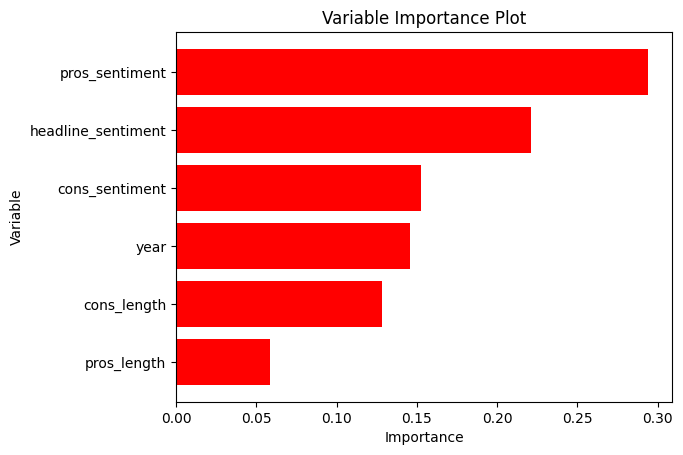

In [93]:
# Initalize the feature importance from the best tree
feature_imp = pd.DataFrame( {'importance':best_rf_model.feature_importances_}, index=features)
feature_imp.sort_values(by='importance', ascending=True)

# Sort the names and importances
sorted_names, sorted_imp = zip(*sorted(zip(features, feature_imp['importance']), key=lambda x: x[1]))

# Plot the bar graph
plt.barh(sorted_names, sorted_imp, label='Importance', color='red')
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Variable Importance Plot")
plt.savefig('./graphs/variable_importance.png')
plt.show()

### Confusion Matrix

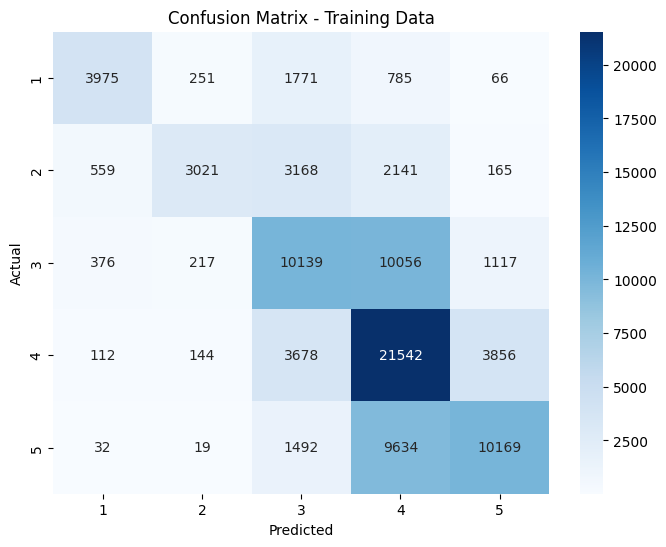

In [94]:
conf_matrix_train_rf = confusion_matrix(y_train, y_train_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./graphs/confusion_matrix.png')
plt.show()

### Prediction vs Actual Distributions

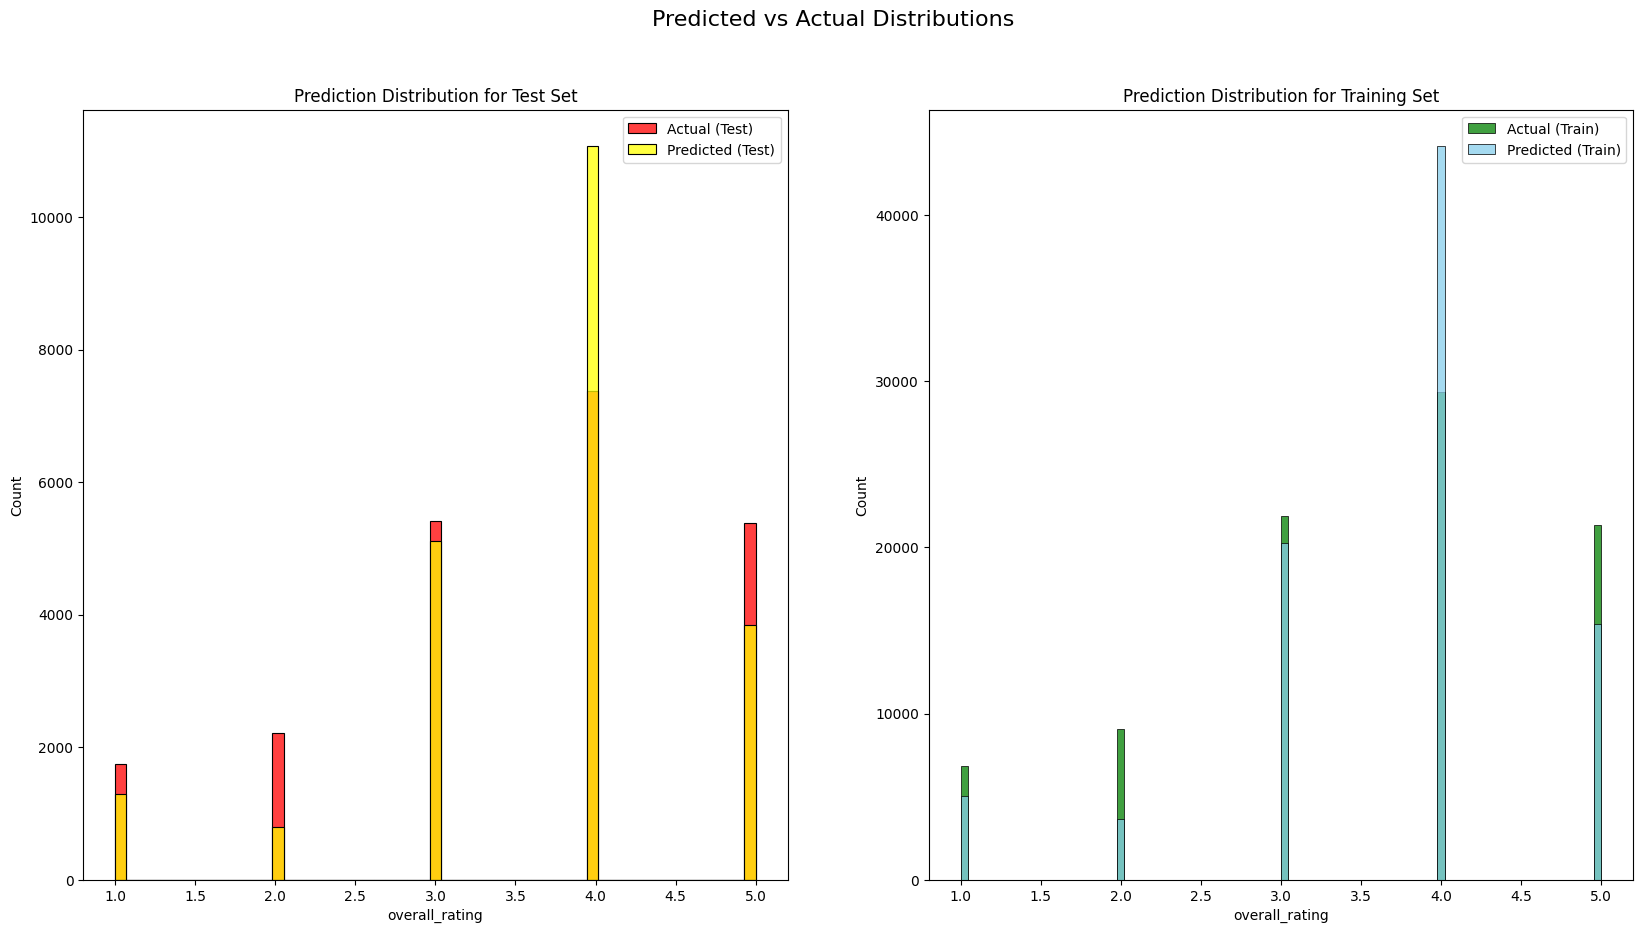

In [95]:
# Consolidated prediction distribution graph
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Predicted vs Actual Distributions', fontsize=16)
# Plot prediction distributions for actual and predicted values in training and test sets
sns.histplot(y_test, label='Actual (Test)', ax=axes[0], kde=False, color = "red")
sns.histplot(y_test_pred_rf, label='Predicted (Test)', ax=axes[0], kde=False, color="yellow")
axes[0].set_title(f'Prediction Distribution for Test Set')
axes[0].legend()

sns.histplot(y_train, label='Actual (Train)', ax=axes[1], kde=False, color = "green")
sns.histplot(y_train_pred_rf, label='Predicted (Train)', ax=axes[1], kde=False, color="skyblue")
axes[1].set_title(f'Prediction Distribution for Training Set')
axes[1].legend()
# sns.histplot(Y_test_pred, label='Predicted (Test)', ax=axes, kde=False, color="red")


# Save the figure
plt.savefig('./graphs/consolidated_prediction_distributions.png')
plt.show()

### Feature Distributions

In [96]:
import math

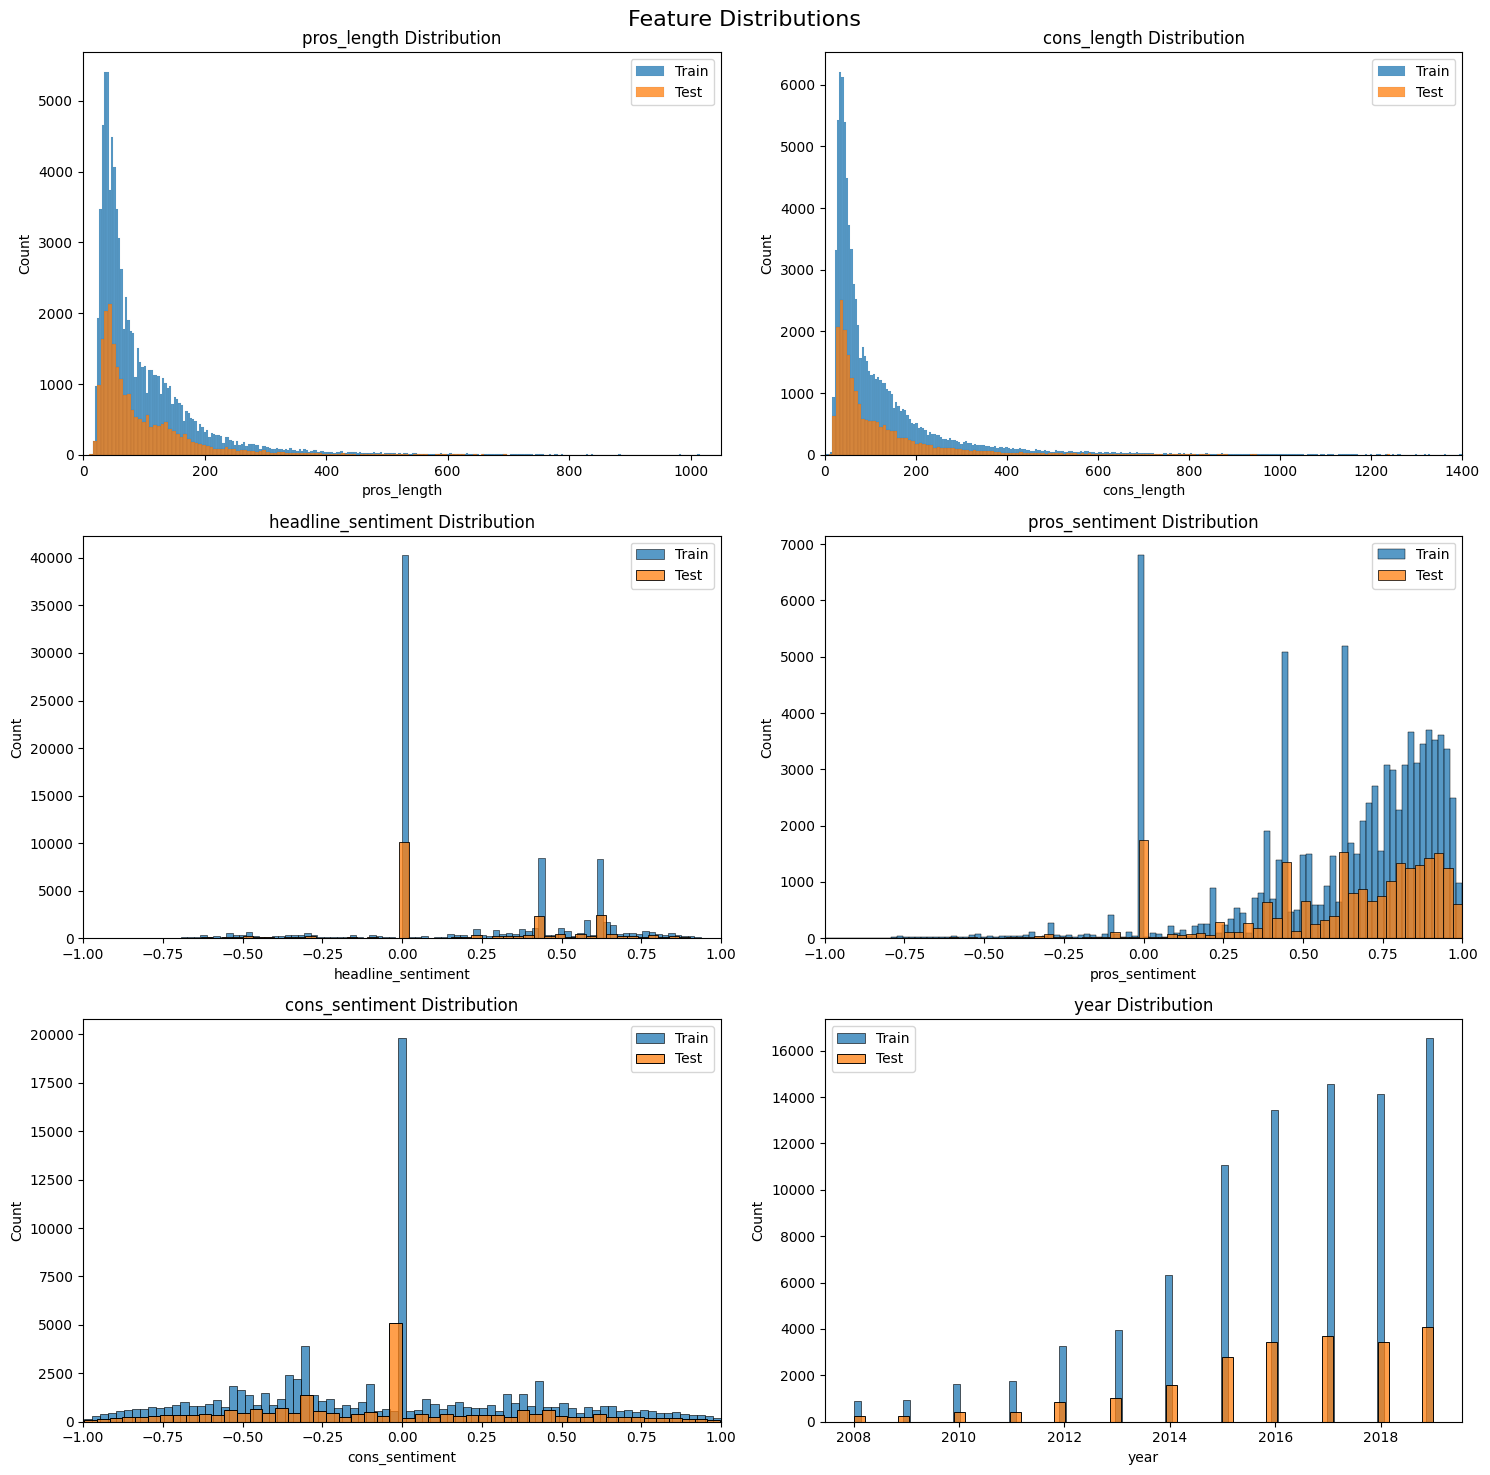

In [97]:
# Consolidated feature distribution graph
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Feature Distributions', fontsize=16)
feature_cols = ['pros_length', 'cons_length', 'headline_sentiment', 'pros_sentiment', 'cons_sentiment','year']

# Plot feature distributions for training and test sets
for i, feature in enumerate(feature_cols):
    
    x = math.floor(i/2)
    y = i%(2)
    sns.histplot(X_train[feature], ax=axes[x, y],label='Train', kde=False)
    sns.histplot(X_test[feature], ax=axes[x, y],label='Test', kde=False)
    axes[x, y].set_title(f'{feature} Distribution')
    axes[x, y].legend()
axes[0, 0].set_xlim(0, 1050)
axes[0, 1].set_xlim(0, 1400) 
axes[1, 0].set_xlim(-1, 1)
axes[1, 1].set_xlim(-1, 1) 
axes[2,0].set_xlim(-1, 1) 
# Remove the empty subplot in the last row and second column
# fig.delaxes(axes[2, 1])

# Adjust layout to prevent clipping of titles
fig.tight_layout()

# Save the figure
plt.savefig('./graphs/consolidated_feature_distributions.png')
plt.show()

### Correlation Heat Map

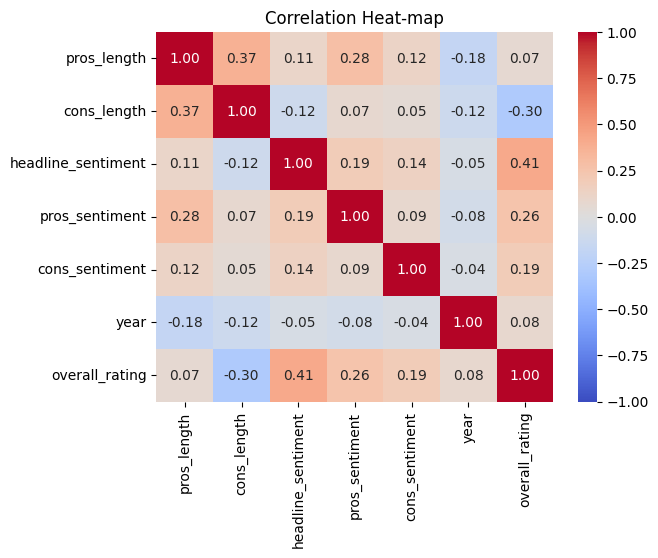

In [98]:
# Correlation heat-map
correlation_matrix = df[['pros_length', 'cons_length', 'headline_sentiment', 'pros_sentiment', 'cons_sentiment','year', 'overall_rating']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heat-map')
plt.savefig('./graphs/correlation_heat_map.png')
plt.show()

### Custom Map: Violin Chart for Sentiment Distribution

/var/folders/jn/v2jdn4p97ms6j6kbs3y53tsc0000gn/T/ipykernel_39049/3183953952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='overall_rating', y=feature, data=df, ax=axes[i], palette='coolwarm', scale='width')
/var/folders/jn/v2jdn4p97ms6j6kbs3y53tsc0000gn/T/ipykernel_39049/3183953952.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='overall_rating', y=feature, data=df, ax=axes[i], palette='coolwarm', scale='width')
/var/folders/jn/v2jdn4p97ms6j6kbs3y53tsc0000gn/T/ipykernel_39049/3183953952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='overall_rating', y=feat

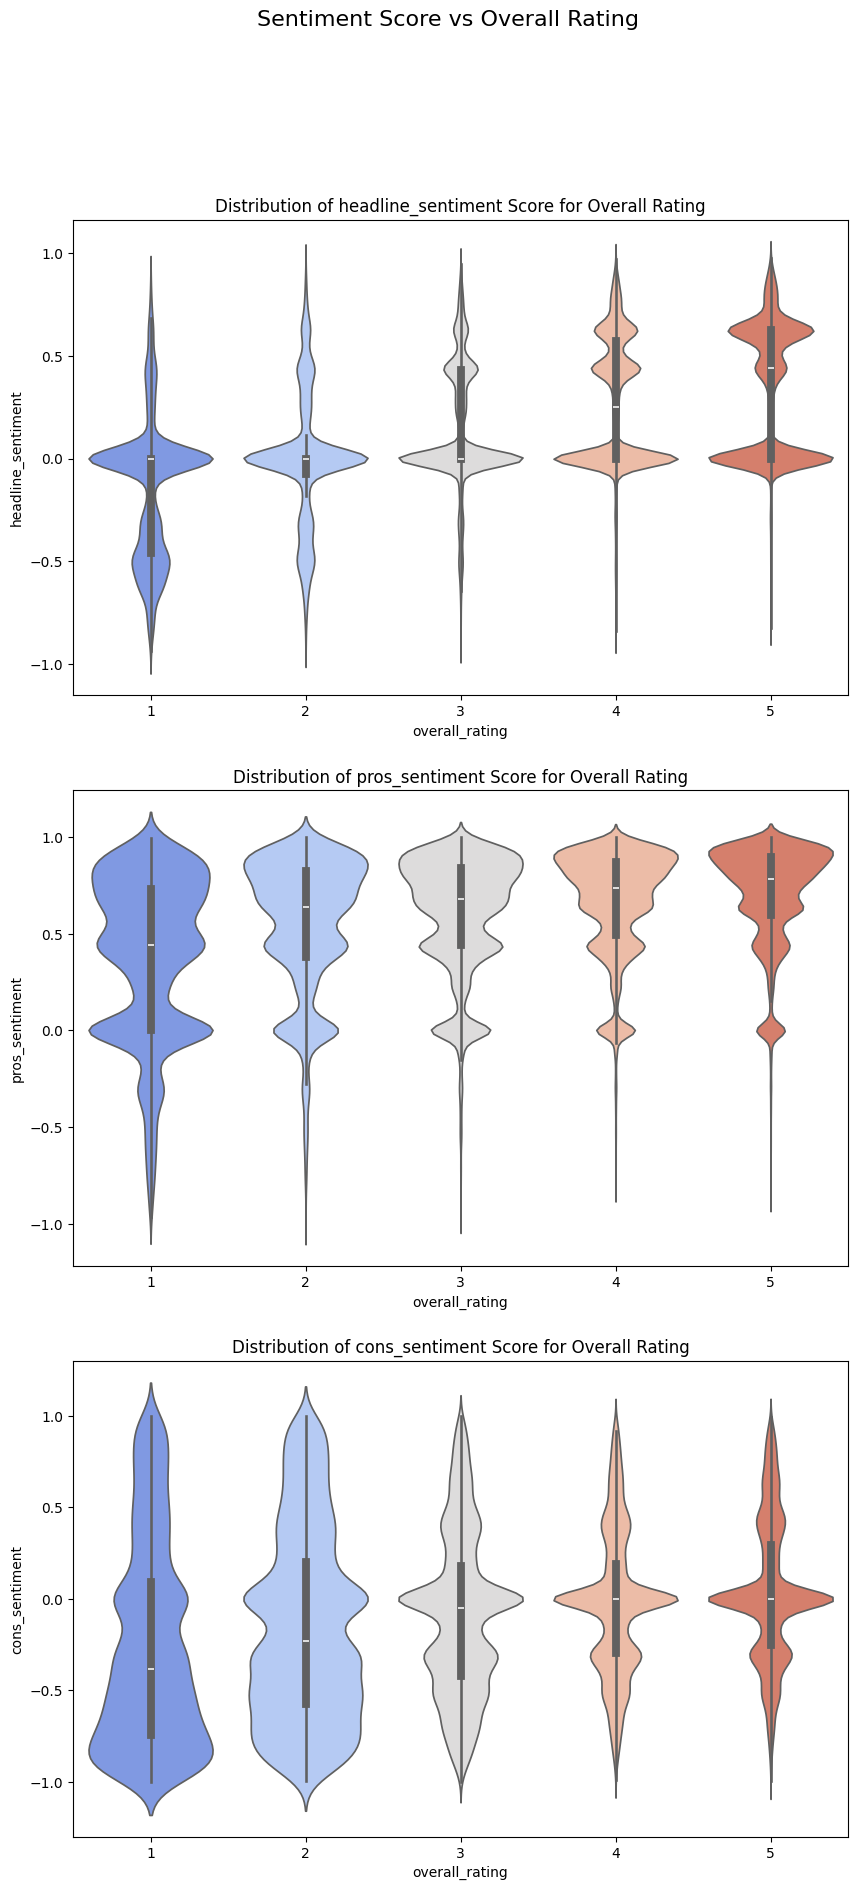

In [99]:
# Consolidated feature distribution graph
fig, axes = plt.subplots(nrows=3, figsize=(10, 21))
fig.suptitle('Sentiment Score vs Overall Rating', fontsize=16)
feature_cols = ['headline_sentiment', 'pros_sentiment', 'cons_sentiment']

# Plot feature distributions for training and test sets
for i, feature in enumerate(feature_cols):
    # Create a violin plot
    sns.violinplot(x='overall_rating', y=feature, data=df, ax=axes[i], palette='coolwarm', scale='width')
    axes[i].set_title(f'Distribution of {feature} Score for Overall Rating')

# Adjust the vertical gap between subplots
plt.subplots_adjust(hspace=0.2)
# Show the plot
plt.savefig('./graphs/feature_distribution.png')
plt.show()


# Predictions on No Response Dataset


### Preprocess Data

In [100]:
dataPred = pd.read_csv("./data/test/glassdoor_test_without_response_v1.csv")
print(dataPred.head())
print(dataPred.shape)


   overall_rating date_review                job_title         location  \
0             NaN  2021-01-15        Financial Advisor              NaN   
1             NaN  2021-06-01               Consultant  Los Angeles, CA   
2             NaN  2021-01-30                  Manager              NaN   
3             NaN  2021-03-18               Consultant              NaN   
4             NaN  2021-02-07   Data Center Technician     Waukesha, WI   

                headline                                               pros  \
0               Good job            Management at the company is wonderful.   
1    Great place to work          Incredible people and established culture   
2  Awesome place to work            Great technical accounting experience !   
3       Senior executive            Good work Life balance in normal season   
4       ok place to work  It was good for me as a starting job out of co...   

                                                cons  year  
0            

In [101]:
dataPred.drop(['overall_rating','small','job_title','location'], errors='ignore',
  axis='columns', inplace=True)

In [102]:
# Specify the columns you want to check for missing values
columns_to_check = ['pros', 'cons', 'headline','year']

# Check for missing values in the specified columns
dataPred[columns_to_check].isna().any()

pros        False
cons         True
headline     True
year        False
dtype: bool

In [103]:
# Fill empty values since there's only a few
dataPred['cons'].fillna('', inplace=True)
dataPred['headline'].fillna('', inplace=True)

### Feature construction

In [104]:

dataPred['pros_length'] = dataPred['pros'].apply(len)
dataPred['cons_length'] = dataPred['cons'].apply(len)
dataPred['headline_sentiment'] = dataPred['headline'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])
dataPred['pros_sentiment'] = dataPred['pros'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])
dataPred['cons_sentiment'] = dataPred['cons'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])


In [105]:
# Save progress
csv_file_out = "./data/postsentimentTestSet.csv"
dataPred.to_csv(csv_file_out,index=False, encoding="utf-8", float_format="%1.6f")

### Predictions

In [106]:
dataPred = dataPred[['year', 'pros_length', 'cons_length', 'headline_sentiment',
       'pros_sentiment', 'cons_sentiment']]
Y_test_pred = best_rf_model.predict(dataPred)

In [107]:
# Save Predictions
csv_file_out = "./data/predictions_randomForest.csv"
np.savetxt(csv_file_out, Y_test_pred, delimiter="\n")

# Actionable Insights

### Imports

In [108]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.util import ngrams

### Preprocess

In [109]:
# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('./data/postsentiment.csv',lineterminator='\n')

# Separate data into high and low ratings
high_ratings = df[(df['overall_rating'] == 4) | (df['overall_rating'] == 5)]
low_ratings = df[(df['overall_rating'] == 1) | (df['overall_rating'] == 2)]

In [110]:

# Function for text processing
def process_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming (you can also use lemmatization)
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]
    return tokens


In [111]:
# Process pros text for high and low ratings
high_pros_tokens = high_ratings['pros'].apply(process_text)
low_pros_tokens = low_ratings['pros'].apply(process_text)

# Process cons text for high and low ratings
high_cons_tokens = high_ratings['cons'].apply(process_text)
low_cons_tokens = low_ratings['cons'].apply(process_text)

### Calculate and Extract Common Phrases

In [112]:
# Function to generate n-grams
def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

In [113]:
# Extract n-grams for high and low ratings
high_pros_ngrams = [phrase for tokens in high_pros_tokens for phrase in extract_ngrams(tokens, 3)]
low_pros_ngrams = [phrase for tokens in low_pros_tokens for phrase in extract_ngrams(tokens, 3)]

# Convert n-grams to strings for easier analysis
high_pros_ngram_strings = [' '.join(phrase) for phrase in high_pros_ngrams]
low_pros_ngram_strings = [' '.join(phrase) for phrase in low_pros_ngrams]

# Calculate frequency of n-grams
high_pros_ngram_freq = pd.Series(high_pros_ngram_strings).value_counts()
low_pros_ngram_freq = pd.Series(low_pros_ngram_strings).value_counts()

# Extract common n-grams
common_high_pros_ngrams = high_pros_ngram_freq.head(10).index.tolist()
common_low_pros_ngrams = low_pros_ngram_freq.head(10).index.tolist()

print("Common phrases in high-rated pros:", common_high_pros_ngrams)
print("Common phrases in low-rated pros:", common_low_pros_ngrams)

Common phrases in high-rated pros: ['work life balanc', 'great place work', 'good work life', 'good work environ', 'great compani work', 'flexibl work hour', 'great work environ', 'life balanc good', 'good place work', 'great work life']
Common phrases in low-rated pros: ['work life balanc', 'good work life', 'flexibl work hour', 'look good resum', 'great peopl work', 'life balanc good', 'good peopl work', 'none none none', 'great place work', 'flexibl work home']


In [114]:
# Repeat for cons

# Extract n-grams for high and low ratings
high_cons_ngrams = [phrase for tokens in high_cons_tokens for phrase in extract_ngrams(tokens, 2)]
low_cons_ngrams = [phrase for tokens in low_cons_tokens for phrase in extract_ngrams(tokens, 2)]

# Convert n-grams to strings for easier analysis
high_cons_ngram_strings = [' '.join(phrase) for phrase in high_cons_ngrams]
low_cons_ngram_strings = [' '.join(phrase) for phrase in low_cons_ngrams]

# Calculate frequency of n-grams
high_cons_ngram_freq = pd.Series(high_cons_ngram_strings).value_counts()
low_cons_ngram_freq = pd.Series(low_cons_ngram_strings).value_counts()

# Extract common n-grams
common_high_cons_ngrams = high_cons_ngram_freq.head(10).index.tolist()
common_low_cons_ngrams = low_cons_ngram_freq.head(10).index.tolist()

print("Common phrases in high-rated pros:", common_high_cons_ngrams)
print("Common phrases in low-rated pros:", common_low_cons_ngrams)

Common phrases in high-rated pros: ['long hour', 'work life', 'life balanc', 'work hour', 'long work', 'busi season', 'big compani', 'larg compani', 'senior manag', 'hard work']
Common phrases in low-rated pros: ['senior manag', 'work life', 'life balanc', 'long hour', 'work hour', 'poor manag', 'upper manag', 'low pay', 'work environ', 'place work']


In [115]:
# Remove duplicates for pros
indexes = [] # add in any visible duplicates
high_pros_bigram_freq = high_pros_ngram_freq.drop(indexes)
common_high_pros_bigrams = high_pros_bigram_freq.head(10).index.tolist()
highpros = dict(high_pros_bigram_freq[common_high_pros_bigrams])


# Remove duplicates for cons

indexes = []  # add in any visible duplicates
low_cons_bigram_freq = low_cons_ngram_freq.drop(indexes)
common_low_cons_bigrams = low_cons_bigram_freq.head(10).index.tolist()
print("Common phrases in high-rated pros:", common_low_cons_bigrams)
lowcons = dict(low_cons_bigram_freq[common_low_cons_bigrams])

Common phrases in high-rated pros: ['senior manag', 'work life', 'life balanc', 'long hour', 'work hour', 'poor manag', 'upper manag', 'low pay', 'work environ', 'place work']


### Plot Wordclouds

In [116]:
# Plot word clouds
def plot_word_cloud(data, title):
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 12).generate_from_frequencies(data)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

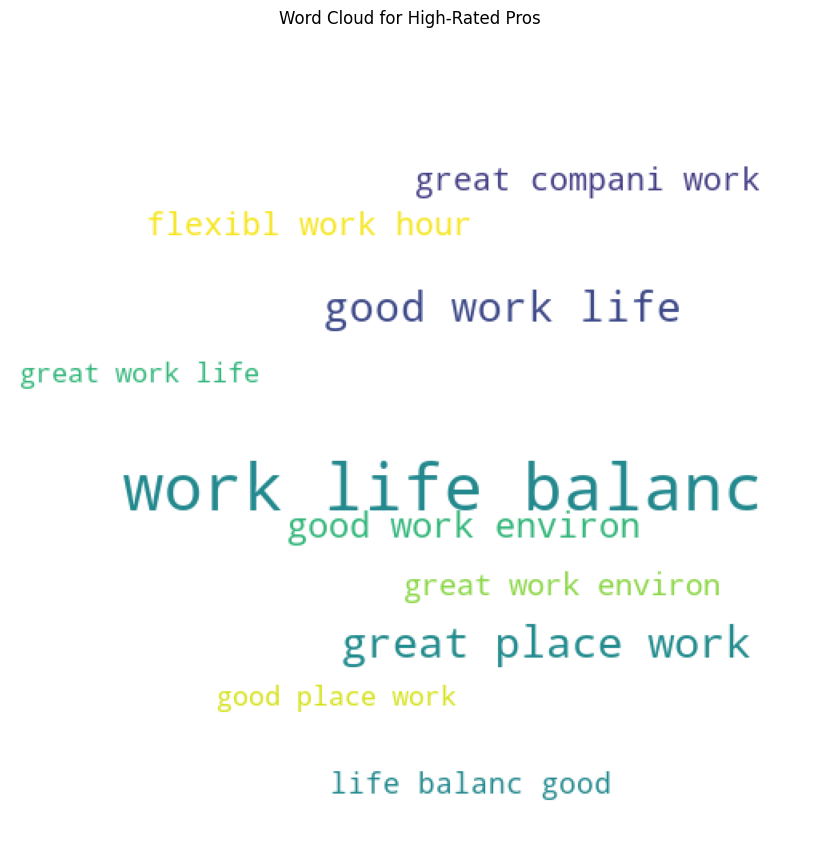

<Figure size 640x480 with 0 Axes>

In [117]:
# Pros
plot_word_cloud((highpros), "Word Cloud for High-Rated Pros")
plt.savefig('./graphs/word_cloud_high_rated_pros.png')


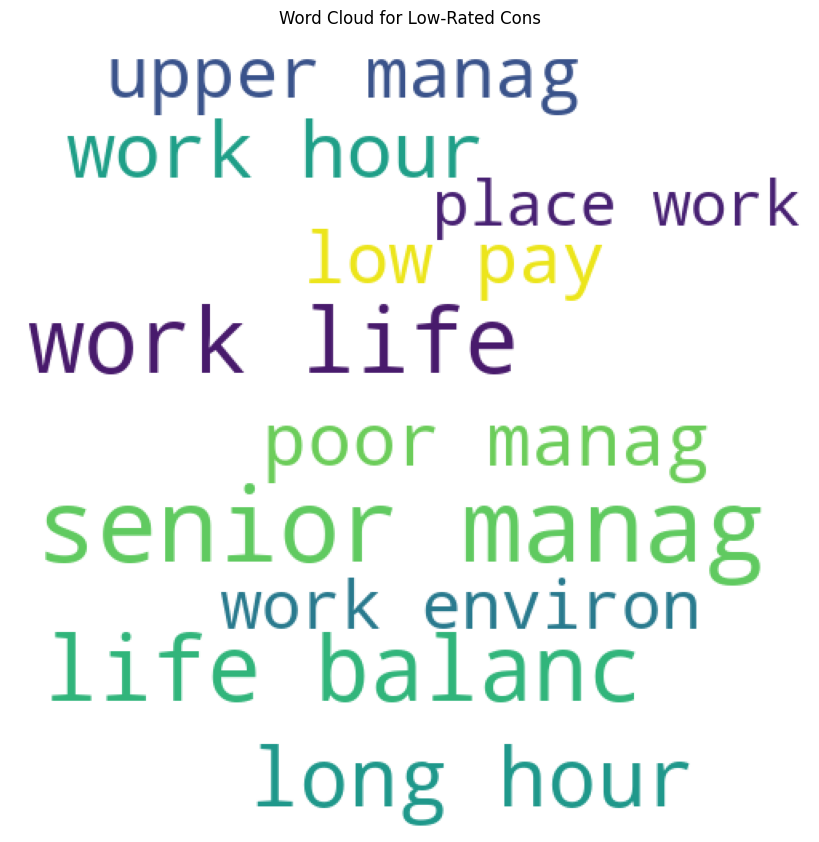

<Figure size 640x480 with 0 Axes>

In [118]:
# Cons
plot_word_cloud(lowcons, "Word Cloud for Low-Rated Cons")
plt.savefig('./graphs/word_cloud_low_rated_cons.png')